In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,callbacks
import random, time

# Read data

In [2]:
df = pd.read_csv("./Data/train.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


# EDA

### Distribution of labels

In [3]:
labels = [label for label in df.columns][2:]
labels

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

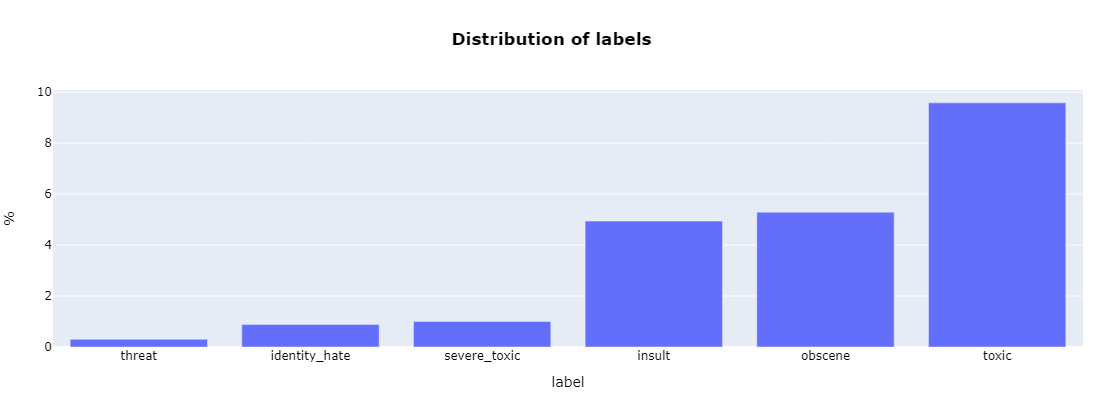

In [339]:
# Calculate positive_class_ratio
num_rows = len(df)
positive_class_ratio = round(100*df[df.columns[2:]].sum()/num_rows,2).sort_values()

# Plot with Plotly
fig = px.bar(positive_class_ratio, x=positive_class_ratio.index, y= positive_class_ratio.values,
             title="Distribution of labels",height=400,width=800)
fig.update_xaxes(title="label")
fig.update_yaxes(title="%")
fig.update_layout(
            title_text="<b>Distribution of labels</b>",
            title_x=0.5,
            title_font_color="black",
            font=dict(color="black")  ,
            margin=dict(r=20, t=90, b=40, l=20),
        )
fig.show()

# !pip install --upgrade "kaleido==0.1.*"
try:
    fig.write_image('./stats/Toxicity_Distribution.png')
except:
    print("Error write_image")

>- There is an **imbalance** between the 6 categories. Comments with `threat` label are the least common.
>- There is also an imbalance within each label as the proportion of positive class is less than **10%** for all categories, and less than **1%** for three categories: `sever_toxic`, `identity_hate` and `threat`. 

The heatmap shows that there is a strong correlation between the terms _`toxic`_, _`insulting`_ and _`obscene`_. Therefore, if a comment has one of these three labels, it is likely to have the others as well.

### Length of the comments - number of words

In [37]:
# Add column "comment_length"
df["comment_length"] = df["comment_text"].apply(lambda x:len(x.split()))

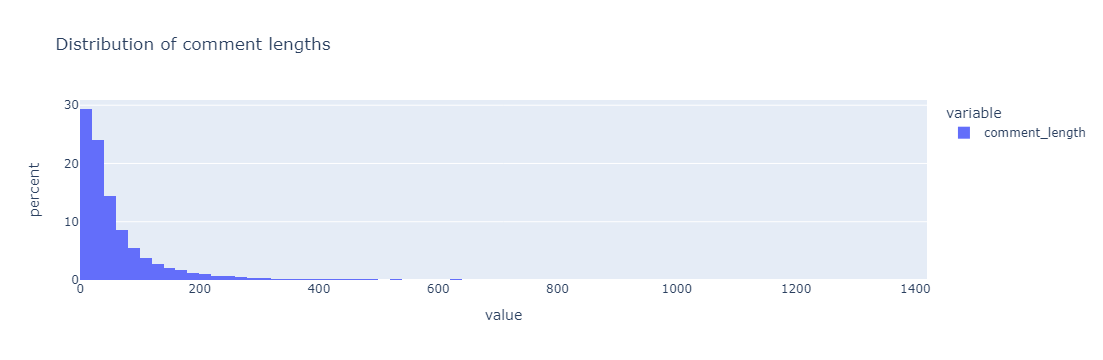

95% of the comments have less than 230 words. Few comments have very high length.


In [46]:
# Distribution of comment lengths
fig = px.histogram(df["comment_length"],title="Distribution of comment lengths",nbins=100,histnorm="percent")
fig.show()

p_95 = int(np.percentile(df["comment_length"].values,95)) # the 95th percentile 
print(f"95% of the comments have less than {p_95} words. Few comments have very high length.")

95% of the comments for label 'toxic' have less than 171 words.
95% of the comments for label 'severe_toxic' have less than 473 words.
95% of the comments for label 'obscene' have less than 162 words.
95% of the comments for label 'threat' have less than 143 words.
95% of the comments for label 'insult' have less than 151 words.
95% of the comments for label 'identity_hate' have less than 178 words.


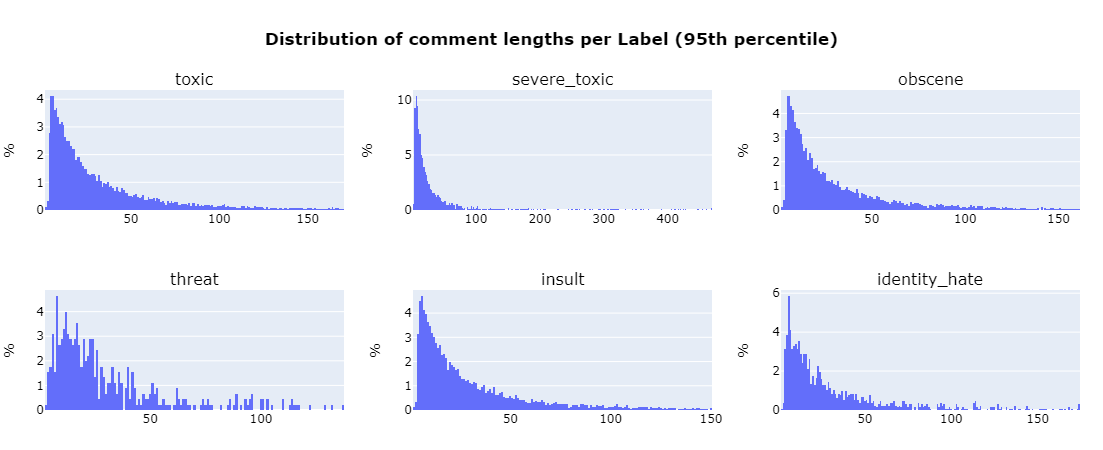

In [54]:
# Distribution of comment lengths per Label

fig = make_subplots(rows=2, cols=3, 
                    subplot_titles=tuple(labels) )

col_id = 0
row_id = 1

for i in range(6):
    comments_i = df.loc[df[labels[i]] == 1, :]['comment_length']
    p_95 = int(np.percentile(comments_i,95)) # the 95th percentile
    comments_i = comments_i[comments_i<p_95]
    print(f"95% of the comments for label '{labels[i]}' have less than {p_95} words.")   
    
    # add subplot
    fig.add_trace(
        go.Histogram(x=comments_i, marker=dict(color="#636EFA"),showlegend=False,name=labels[i],
                     nbinsx=250,histnorm="percent"),
        row=row_id, col=1+col_id
    )    
    fig.update_yaxes(title_text="%", row=row_id, col=1+col_id)
    col_id +=1
    if col_id ==3:
        col_id = 0
        row_id = 2
        
# update layout
fig.update_layout(
    title_text = "<b>Distribution of comment lengths per Label (95th percentile)<b>", 
    title_x=0.5,
    title_font_color="black",
    font=dict(color="black")  ,
    margin=dict(r=20, t=90, b=40, l=20),
    height=450)

fig.show() 

# save image
try:
    fig.write_image('./stats/comments_length.png')
except:
    print("Error write_image")

- We can see that the distribution of the comment lengths for the labels are very similar. 
- 95% of the comments have less than 180 words for all labels except for 'sever_toxic' (473 words).

### Correlation matrix

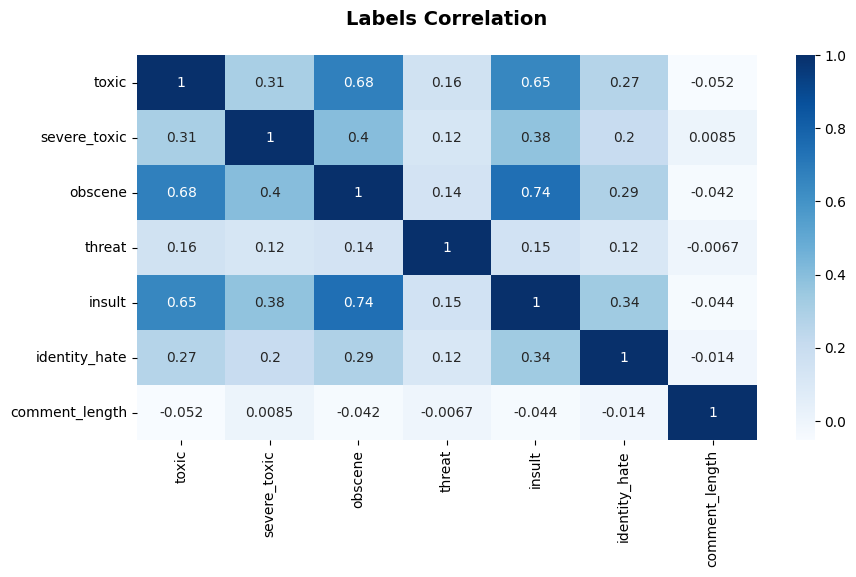

In [344]:
labels_cor = df.drop(["id","comment_text"],axis=1).corr(numeric_only=True)

plt.figure(figsize=(10,5))
sns.heatmap(labels_cor, annot=True, cmap='Blues')
plt.title("Labels Correlation\n",size = 14, weight = 'bold')
plt.savefig('./stats/labels_correlation.png',bbox_inches='tight')

### Word cloud: The most common words

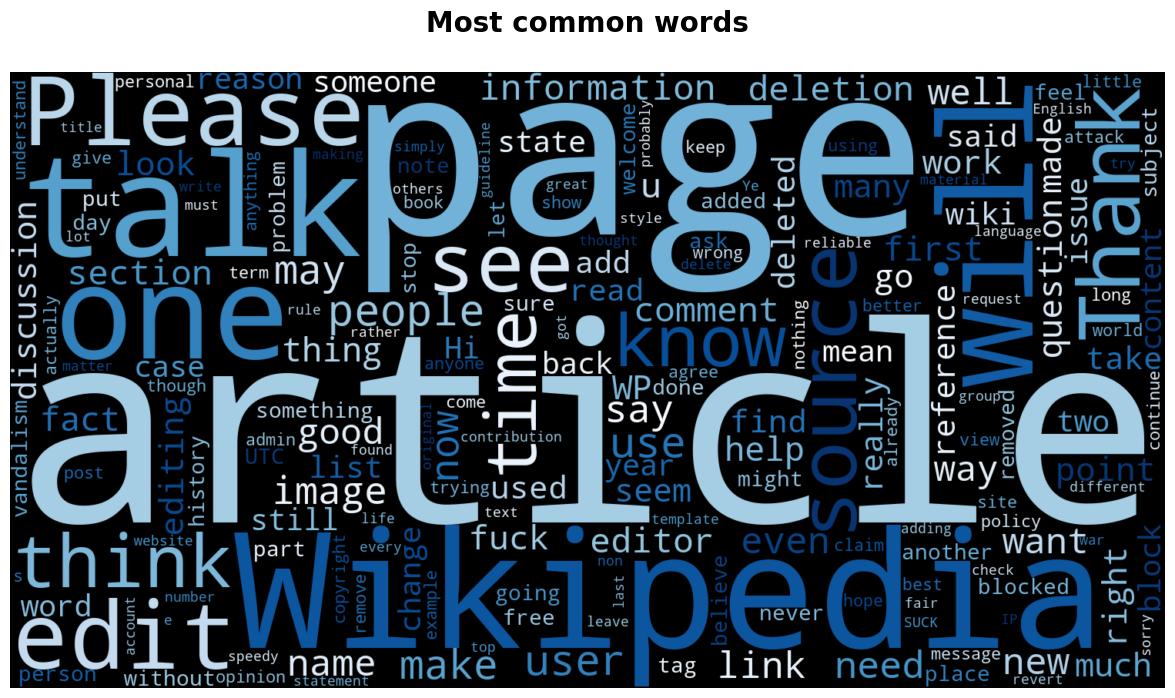

In [345]:
all_comments =  pd.Series(df["comment_text"]).str.cat(sep=' ')

from wordcloud import WordCloud
wordcloud = WordCloud(background_color='black',max_words=200,
                      width=1500,height=800,max_font_size=500,collocations=False)
# Generate the word cloud
wordcloud.generate(all_comments)

# display the wordcloud
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud.recolor(colormap="Blues"), interpolation='bilinear')
plt.axis("off")
plt.title(f"Most common words\n",size = 20, weight = 'bold')
plt.savefig('./stats/wordcloud.png')

### Word cloud: The most common toxic words

Disclaimer: It contains text that may be considered profane, vulgar, or offensive.

In [346]:
toxic_comments = df[df[labels].sum(axis=1)>0]["comment_text"] # at least on label is positive
toxic_text = pd.Series(toxic_comments).str.cat(sep=' ')

from wordcloud import WordCloud
toxic_wordcloud = WordCloud(background_color='black',max_words=200,
                            width=1500,height=800,max_font_size=500,collocations=False)
# Generate the word cloud
toxic_wordcloud.generate(toxic_text)

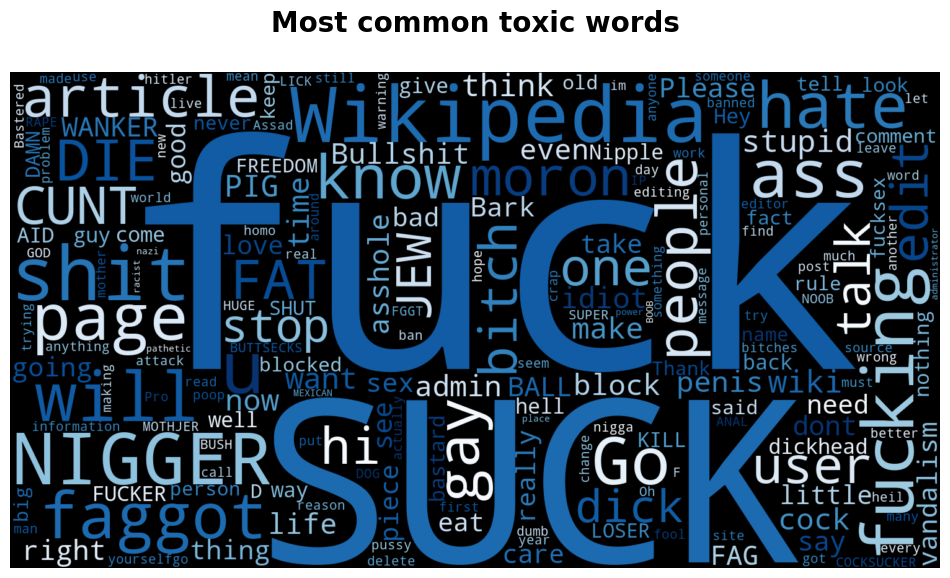

In [347]:
# Disclaimer: It contains text that may be considered profane, vulgar, or offensive.

plt.figure(figsize=(12, 7))
plt.imshow(toxic_wordcloud.recolor(colormap="Blues"), interpolation='bilinear')
plt.axis("off")
plt.title(f"Most common toxic words\n",size = 20, weight = 'bold')
plt.savefig('./stats/toxic_wordcloud.png');
plt.show()

#### Top toxic words per label

In [348]:
toxic_wordclouds = []
for i in range(6):
    toxic_comments_i = df.loc[df[labels[i]] == 1, :]["comment_text"] # at least on label is positive
    toxic_text_i = pd.Series(toxic_comments_i).str.cat(sep=' ')
    
    toxic_wordcloud_i = WordCloud(max_words=200)
    # Generate the word cloud
    toxic_wordcloud_i.generate(toxic_text_i)
    toxic_wordclouds.append(toxic_wordcloud_i.words_)

toxic_wordclouds_df = pd.DataFrame(toxic_wordclouds).T.round(2).fillna(0)
toxic_wordclouds_df.columns = labels


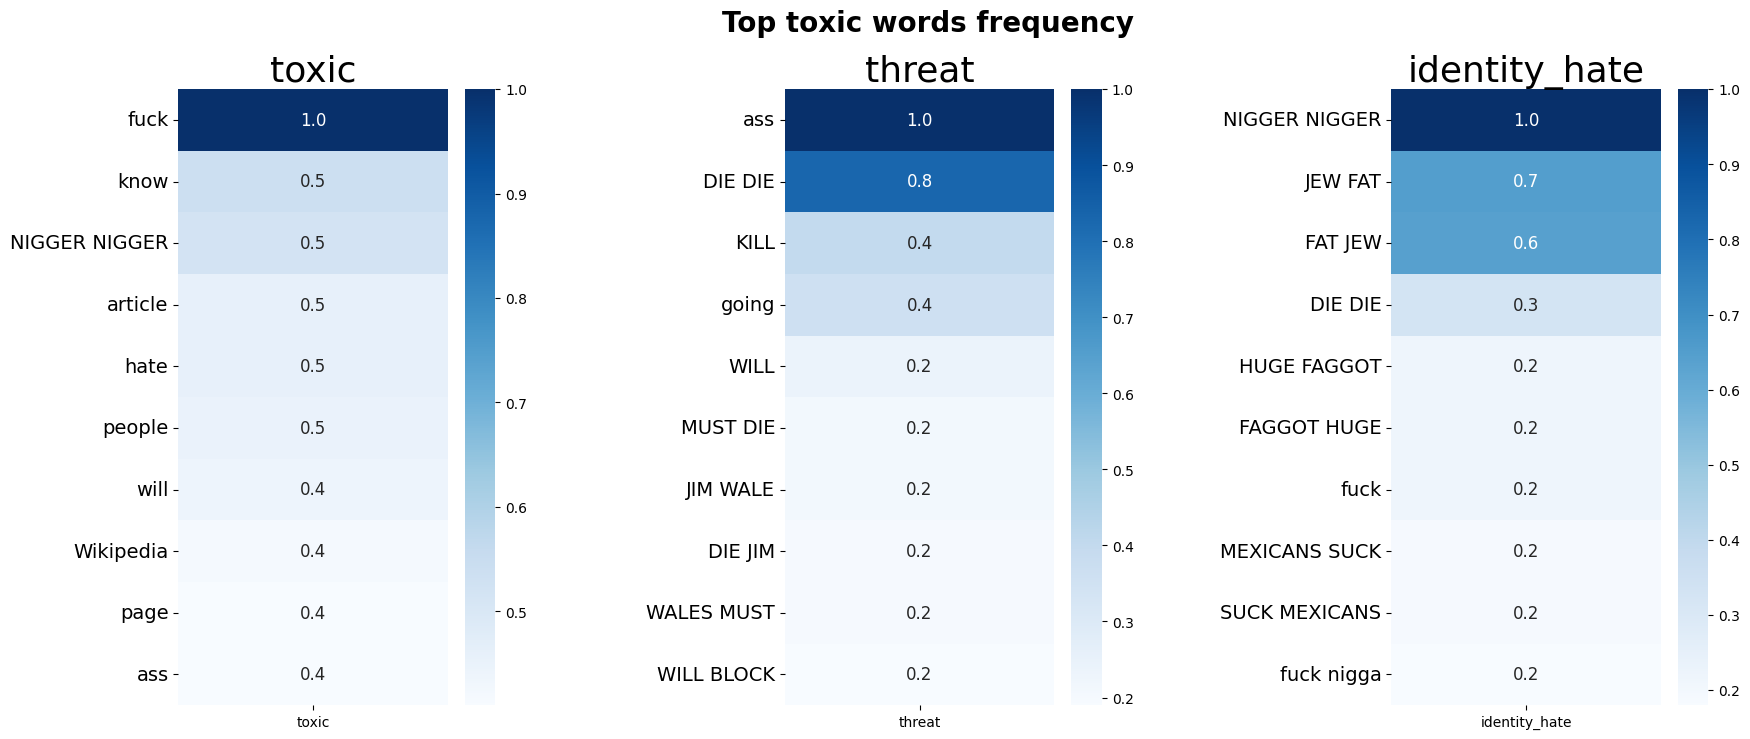

In [349]:
# For better visibility, we will select only 3 labels:

selected_labels = ['toxic','threat','identity_hate']
toxic_wordclouds_selected = toxic_wordclouds_df[selected_labels]

fig, ax = plt.subplots(1, 3, figsize=(20,8), sharex=False)
plt.subplots_adjust(wspace=0.8,hspace=0.8)
fig.suptitle('Top toxic words frequency', fontsize=20, weight = 'bold')

axes =ax.ravel()
for i in range(3):
    label = selected_labels[i]
    top_words_i = pd.DataFrame(toxic_wordclouds_selected[label].sort_values(ascending=False)[:10])
    sns.heatmap(top_words_i, fmt='.01f', annot=True,cmap="Blues",ax=axes[i],annot_kws={"size": 12})

    axes[i].title.set_text(selected_labels[i])
    axes[i].title.set_size(26)
    axes[i].tick_params(axis='y', labelsize=14)

plt.savefig('./stats/Top10_toxic_words.png',bbox_inches='tight');

There is a significant difference in the top 10 toxic words between the different labels, as shown in the graph above.

## Evaluation metric and handling unbalanced dataset

>**To deal with class inbalance, we will:**
>1. Use stratified data split instead of the traditional train_test_split..
>2. Build a custom binary cross-entropy loss function with class weights.
>3. Text Data augmentation to increase the number of minority labels (namely 'threat' and 'identity_hate'). We translate the given comment into French, German and Spanish and then back into English (back-translation).
>4. Use the the **F1-score** and **AUC** as evaluation metrics instead of the accuracy.

# Data Preprocessing

In [350]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
# from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

def clean_text(text):
    # 1. find urls and replace them with 'urlplaceholder'
    url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    text = re.sub(url_regex, 'urlplaceholder', text)

    # 2. Convert to lowercase
    text = text.lower().strip() 

    # 3. Remove punctuation characters
    text = re.sub(r"[^a-zA-Z0-9]", " ", text) 

    # 4. Remove stopwords
    stop_words = set(stopwords.words('english'))
    clean_tokens = [word for word in text.split() if word not in stop_words]
    
    # 6. Lemmatization
    lemmatizer = WordNetLemmatizer()
    # 6.1 Reduce words to their root form
    lemmed = [lemmatizer.lemmatize(w) for w in clean_tokens]
    # 6.2 Lemmatize verbs by specifying pos
    clean_tokens = [WordNetLemmatizer().lemmatize(w, pos='v') for w in lemmed]

    cleaned_text = ' '.join(clean_tokens)
    
    return cleaned_text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alaed\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [351]:
start = time.time()
df["clean_comment"] = df["comment_text"].apply(clean_text)
end = time.time()
print(f"Execution time: {int((end-start)/60)} minutes and {int((end-start)%60)} seconds")
df.head()

Execution time: 1 minutes and 13 seconds


id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  comment_length  \
0             0        0       0       0              0              43   
1             0        0       0       0              0              17   
2             0        0       0       0              0              42   
3             0        0       0       0              0             113   
4             0        0       0       0              0              13   

                                       clean_comment  
0  explanation edit make username hardcore metall...  
1  aww match background colour seemingly stick th...  
2  hey man really try edit war guy constantly rem...  
3  make real suggestion improvement wonder sectio...  
4                      sir hero chance remember page

## Iterative_train_test_split
To deal with data imbalances, we will use the [iterative stratification for multi-label data](http://scikit.ml/api/skmultilearn.model_selection.iterative_stratification.html) instead of the traditional train_test_split.

In [352]:
# !pip install scikit-multilearn
from skmultilearn.model_selection import iterative_train_test_split

# Split into X and y
X = df[['clean_comment','comment_text']].to_numpy()
# X = df[['clean_comment']].to_numpy()
y = df[labels].to_numpy()

X_train, y_train, X_test, y_test = iterative_train_test_split(X.reshape((len(df), -1)), y, test_size = 0.3)

X_train = tf.squeeze(X_train).numpy()
y_train = tf.squeeze(y_train).numpy()
X_test = tf.squeeze(X_test).numpy()
y_test = tf.squeeze(y_test).numpy()

print(f"X shape:",X.shape)
print(f"X_train shape:",X_train.shape)
print(f"X_test shape:",X_test.shape)
print(f"y_train shape:",y_train.shape)
print(f"y_test shape:",y_test.shape)

X shape: (159571, 2)
X_train shape: (111699, 2)
X_test shape: (47872, 2)
y_train shape: (111699, 6)
y_test shape: (47872, 6)


## Calculate class weights
We will use these weights to construct our own binary cross-entropy loss function.

In [353]:
class_0_weights = []
class_1_weights = []

for c in labels:
    class_0_weights.append(df.shape[0]/(2*np.count_nonzero(df[c]==0)))
    class_1_weights.append(df.shape[0]/(2*np.count_nonzero(df[c]==1)))    
weights = np.array([class_0_weights,class_1_weights]).T
weights

array([[  0.55300221,   5.21678436],
       [  0.50504824,  50.02225705],
       [  0.52795424,   9.44318854],
       [  0.50150227, 166.91527197],
       [  0.52596345,  10.12891964],
       [  0.50444154,  56.78683274]])

## NLP data augmentation with googletrans

https://www.analyticsvidhya.com/blog/2020/11/handling-imbalanced-data-machine-learning-computer-vision-and-nlp/

https://www.analyticsvidhya.com/blog/2022/02/text-data-augmentation-in-natural-language-processing-with-texattack/

In [10]:
from googletrans import Translator
translator = Translator()

def google_translation(text,lang: str):
    lang_translation = translator.translate(text, dest=lang)
    return lang_translation.text
    
def back_translation(text,lang: str):
    # Translation
    text_trans = google_translation(str(text),lang)
    # Backtranslation 
    text_backtrans = google_translation(text_trans,"en")
    text_backtrans_clean = clean_text(text_backtrans)
    
    return text_backtrans_clean

In [11]:
def data_augmentation():
    #v1. Get indexes of messages to be translated
    y_train_df = pd.DataFrame(y_train,columns=labels)
    indexes = list(y_train_df[(y_train_df['threat']==1) | (y_train_df['identity_hate']==1)].index)
    X_train_to_aug = X_train[indexes,1]
      
    # 2. Google trans API

    X_train_aug = []
    y_train_indexes = []
    
    langs = ['de','fr','es']
    
    start = time.time()
    
    for lang in langs:
        print(f"Google translation: {lang}")
        i = 0
        for text in X_train_to_aug: 
            i +=1
            print(i,lang)        
            text = text.decode('utf-8')
            text_clean = X_train[indexes,0][i-1].decode('utf-8')        
            try:
                text_backtrans_clean = back_translation(text,lang)
                ### Only append new text that is different from existing clean text.
                if text_backtrans_clean != text_clean:
                    X_train_aug.append(text_backtrans_clean)
                    y_train_indexes.append(indexes[i-1])
            except:
                print(f"Error translating text with index {indexes[i-1]}: {str(text)}")
                
    end = time.time()
    print(f"Execution time: {int((end-start)/60)} minutes and {int((end-start)%60)} seconds")
    
    # save results
    pd.DataFrame(X_train_aug,columns=['text']).to_csv('./googletrans/X_train_aug.csv',index=False)
    
    y_train_aug = y_train_df.iloc[y_train_indexes][labels].values
    pd.DataFrame(y_train_aug,columns=labels).to_csv('./googletrans/y_train_aug.csv',index=False)

In [ ]:
# # Uncomment to run the 'data_augmentation' function
# data_augmentation()

In [354]:
# Read augmented text data (the output of the previous cell)
X_train_aug = pd.read_csv("./googletrans/X_train_aug.csv")['text'].to_list()
X_train_aug=np.asarray(X_train_aug).astype(str)

y_train_aug = pd.read_csv("./googletrans/y_train_aug.csv").to_numpy()

### concatenate X_train and X_train_aug

In [355]:
# X_train initially contains clean_messages and initial messagaes --> keep only the former 
if X_train.ndim>1:
    X_train = X_train[:,0]
    X_test = X_test[:,0]

In [356]:
# X_train_with_aug = np.concatenate((X_train,X_train_aug)).astype('str') ### returned error (Unable to allocate 23.4 GiB for an array with shape (115163,) and data type <U54458)
X_train_with_aug = np.concatenate((X_train,X_train_aug))
y_train_with_aug = np.concatenate((y_train,y_train_aug))

# TextVectorization and Embedding

Now, let's turn text into numbers.

## TextVectorization
We'll keep all the parameters default except for `max_tokens` (the number of unique words in our dataset) and `output_sequence_length` (our desired output length for each vectorized sentence).

In [357]:
from keras.layers import TextVectorization
    
def Text_Vectorization(X_train_array):
    
    # 1. Set the `Output_sequence_length` parameter:    
    clean_Tokens_length = [len(str(sentence).split()) for sentence in X_train_array]
    
    clean_Tokens_length_df = pd.DataFrame(clean_Tokens_length,columns=['len'])
    fig = px.histogram(clean_Tokens_length_df, x="len",title="Tokens length")
    fig.show()

    SEQ_tokens_length = int(np.percentile(clean_Tokens_length,95))
    print(f"SEQ_tokens_length:",SEQ_tokens_length)

    # 2. How many words are in our vocabulary? 
    list_tokens = []
    for sentence in X_train_array:
        for token in str(sentence).split():
            list_tokens.append(token)
    set_tokens = set(list_tokens)     
    
    MAX_tokens = len(set_tokens)
    print(f"MAX_tokens:",MAX_tokens)

    # 3. TextVectorization
    tokens_TextVectorization = TextVectorization(max_tokens=MAX_tokens,output_sequence_length=SEQ_tokens_length)
    # Adapt text vectorizer to training sentences
    tokens_TextVectorization.adapt(X_train_array)
    
    # Get Vocabulary
    words_in_vocab = tokens_TextVectorization.get_vocabulary()
    print(f"Number of words in vocab: {len(words_in_vocab)}")
    print(f"Top 5 most common words: {words_in_vocab[:5]}") 
    print(f"Bottom 5 least common words: {words_in_vocab[-5:]}")
    
    return SEQ_tokens_length,MAX_tokens,tokens_TextVectorization,words_in_vocab

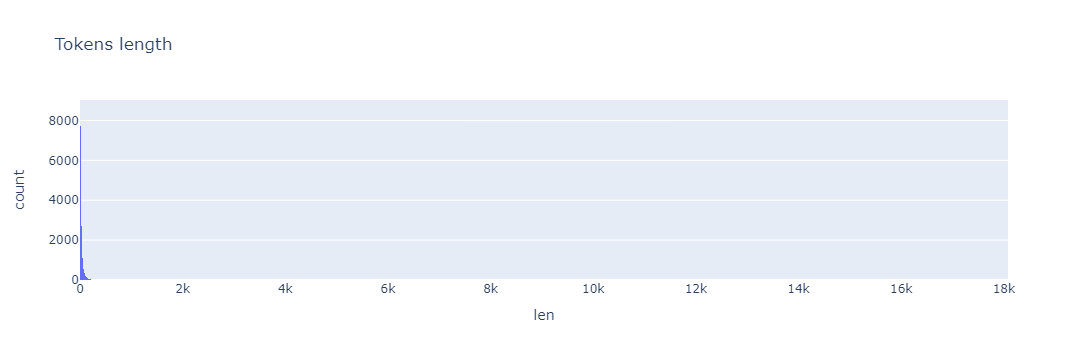

SEQ_tokens_length: 118
MAX_tokens: 152636
Number of words in vocab: 126309
Top 5 most common words: ['', '[UNK]', 'article', 'page', 'wikipedia']
Bottom 5 least common words: ['0000035', '000002000004000008000016', '000001', '00000001', '00000']


In [358]:
SEQ_tokens_length,MAX_tokens,tokens_TextVectorization,words_in_vocab = Text_Vectorization(X_train_with_aug)

## Embedding
We will create a trainable embedding layer using TensorFlow's [`Embedding`](https://www.tensorflow.org/tutorials/text/word_embeddings) layer.

As our model learns (by going through many different examples of abstract sentences and their labels), it'll update its embedding to better represent the relationships between tokens in our corpus.

In [359]:
from keras.layers import Embedding
tokens_Embedding = Embedding(input_dim=MAX_tokens,
                             input_length=SEQ_tokens_length,
                             output_dim=128,mask_zero=True)

In [360]:
# Show an embedding example

# Get a random comment from training set
random_comment = random.choice(X_train)
print(f"Original text:\n{random_comment}\
      \n\nEmbedded version:")

# Embed the random sentence 
sample_embed = tokens_Embedding(tokens_TextVectorization(random_comment))
sample_embed

Original text:
b'redirect talk typhoon lee 1981'      

Embedded version:


<tf.Tensor: shape=(118, 128), dtype=float32, numpy=
array([[-0.03251101,  0.04515124, -0.03700467, ...,  0.04370277,
         0.04264292, -0.02657102],
       [ 0.00315177, -0.02855107, -0.00408877, ..., -0.00592627,
         0.0436824 ,  0.03372279],
       [-0.02734869, -0.04169609, -0.03950787, ...,  0.04439935,
         0.04843087, -0.04887197],
       ...,
       [ 0.02402308, -0.01606181,  0.00692506, ..., -0.02379112,
        -0.02406944, -0.01556461],
       [ 0.02402308, -0.01606181,  0.00692506, ..., -0.02379112,
        -0.02406944, -0.01556461],
       [ 0.02402308, -0.01606181,  0.00692506, ..., -0.02379112,
        -0.02406944, -0.01556461]], dtype=float32)>

# Create datasets
The [`tf.data`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) API provides methods which enable faster data loading.

This will ensure that TensorFlow loads our data onto the GPU as quickly as possible, resulting in faster training times.

In [361]:
# Turn our data into TensorFlow Datasets
BATCH_size = 512
AUTO = tf.data.AUTOTUNE

train_dataset = tf.data.Dataset.from_tensor_slices((X_train,y_train)).shuffle(10000).batch(BATCH_size).prefetch(AUTO)
train_dataset_aug = tf.data.Dataset.from_tensor_slices((X_train_with_aug,y_train_with_aug)).shuffle(10000).batch(BATCH_size).prefetch(AUTO)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test,y_test)).batch(BATCH_size).prefetch(AUTO)

# Modelling and Evaluation

Model structure:
```
Input (text) -> TextVectorization -> Embedding -> Custom_Layers -> Output (sigmoid)
```

The main component we'll be changing throughout is the `Custom_Layers` component.\
More specifically, we'll be building the following:
* **Model 1**: A simple Dense model
* **Model 2**: LSTM model
* **Model 3**: GRU model
* **Model 4**: 1D Convolutional Neural Network
* **Model 5**: TF Hub Pretrained Feature Extractor - Universal Sentence Encoder (USE)

> To ensure that we don't reuse trained embeddings (and thus avoid data leakage between models), we will create a new `Embedding` layer for each model. \
> The `TextVectorisation` layer can be reused as it will not be updated during training.

## Create functions to train and evaluate our models

In [363]:
def build_model(model_layers,model_name,loss_function):
    tf.random.set_seed(42)
    inputs = layers.Input(shape=[],dtype=tf.string)
    x = tokens_TextVectorization(inputs)
    tokens_Embedding = Embedding(input_dim=MAX_tokens,
                                 input_length=SEQ_tokens_length,
                                 output_dim=128,mask_zero=True)
    x = tokens_Embedding(x)
    
    for layer in model_layers:
        x = layer(x)
        
    outputs = layers.Dense(len(labels),activation="sigmoid")(x)
    model = keras.Model(inputs,outputs,name=model_name)
    
    model.compile(loss = loss_function,
                   optimizer=keras.optimizers.Adam(),
                   metrics=['accuracy',
                            keras.metrics.AUC(multi_label=True,name='auc'),
                            keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
                           ])
    model.summary()  
    return model


def compile_model(model,loss_function,learnin_rate):
    model.compile(loss = loss_function,
                   optimizer=keras.optimizers.Adam(learning_rate=learnin_rate),
                   metrics=['accuracy',
                            keras.metrics.AUC(name='auc'),
                            keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
                           ])

In [364]:
def train_model(model,train_dataset,test_dataset,epochs):
    
    # 1. Callbacks
    model_ckpt = keras.callbacks.ModelCheckpoint("./models_ckpt/"+model.name,
                                                 save_best_only=True,save_weights_only=True)    
    early_stopping = keras.callbacks.EarlyStopping(patience=4,monitor='val_loss', 
                                                   verbose=1,
                                                   restore_best_weights=True)
    
    reduce_lr = keras.callbacks.ReduceLROnPlateau(patience=2,monitor='val_loss', factor=0.2,min_lr=1e-7)
    
    # 2. Train the model
    history = model.fit(train_dataset,epochs=epochs,
                        validation_data=test_dataset,
                        callbacks=[model_ckpt,early_stopping,reduce_lr])
    # save history
    pd.DataFrame(history.history).to_csv("./stats/history_"+model.name+".csv",index=False)
    
    # 3. Load the best model
    try:
        # model = keras.models.load_model("./models_ckpt/"+model.name,
        #                                 custom_objects={'loss': get_weighted_loss(weights)})
        model.load_weights("./models_ckpt/"+model.name)
        print("The best model is loaded...")
    except:
        print("Error loading the best model!")
    
    return history

In [365]:
def plot_metrics(history,model_name,list_metrics=['loss','auc']):
    """Plot list of metrics"""
    for metric in list_metrics:
        train_metric = history.history[metric]
        val_metric = history.history[f"val_{metric}"]
        epochs = range(len(history.history[metric]))
        
        plt.figure(figsize=(7, 5))
        plt.plot(epochs, train_metric, label=f"training_{metric}")
        plt.plot(epochs, val_metric, label=f"val_{metric}")
        plt.title(f"{str.upper(metric)} - {model_name}")
        plt.xlabel('Epochs')
        plt.legend()

In [366]:
from sklearn.metrics import accuracy_score, roc_curve, auc, roc_auc_score,\
                        precision_recall_fscore_support,classification_report

def evaluate_model(probs,preds,y_true,labels,label_inedx,plot_ROC_AUC=False):
    """
    - Print AUC, accuracy, precision, recall, and f1_score on the test set
    - Plot ROC AUC
    
    Parameters
    ----------- 
        probs: an array of predicted probabilities 
        preds: an array of predictions
        y_true: true y values 
        labels (list): model's labels (toxic, severe_toxic, obscene, threat, insult, identity_hate)
        label_inedx (int): label index, in range(0,6)
        plot_ROC_AUC (boolean): plot ROC AUC or not, default=False
    """
    
    y_probs = probs[:, label_inedx]
    y_pred = preds[:, label_inedx]
    y_true = y_true[:,label_inedx]
    
    print(f"\n{labels[label_inedx]}:")
    print("#"*50)
    
    fpr, tpr, threshold = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')       
       
    # Get accuracy over the test set
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy:.4f}')
    
    # Get precision, recall, and F-measure
    precision,recall,f1_score,_, = precision_recall_fscore_support(y_true, y_pred,average="weighted")    
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1_score: {f1_score:.4f}')    
    
    # Plot ROC AUC
    if plot_ROC_AUC:
        plt.figure()
        plt.title(f"Receiver Operating Characteristic - {labels[label_inedx]}")
        plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
        plt.legend(loc='lower right')
        plt.plot([0, 1], [0, 1], 'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()

In [367]:
def get_metrics_per_class(y_test, y_pred,probs,model_name,labels):
    """
    Build a dataframe showing the main classification metrics 
        per label (toxic, severe_toxic...) and class (0, 1 and weigted avg).
    Metrics: Accuracy, ROC, f1_score,precision 
    
    Parameters
    ----------- 
        y_test: true y values 
        y_pred: predicted y values
        probs: an array of predicted probabilities
        model_name (str): the model name
        labels (list): model's labels (toxic, severe_toxic, obscene, threat, insult, identity_hate)  
        
    Returns
    ----------- :
        df_metrics_report: A dataframe containing classification metrics 
            per category (toxic, severe_toxic...) and class (0, 1 and weigted avg)
    """
    
    class_list = ["0","1","weighted avg"]
    reports_list = []
    
    for indice,category in enumerate(labels):
        # 1. calssification report        
        report = classification_report(y_test[:,indice], y_pred[:,indice], output_dict=True)
        
        # 2. accuracy
        try:
            accuracy = accuracy_score(y_test[:,indice], y_pred[:,indice])
        except:
            accuracy = np.nan
            
        # 3. roc_auc_score
        try:
            roc = roc_auc_score(y_test[:,indice], probs[:,indice])
        except:
            roc = np.nan
            
        # 4. Build the list of dicts (will be used to create a dataframe)
        for class_name in class_list:
            try:
                report_class = report.get(class_name)
                
                # Accuracy and roc_auc scores are available only for weighted avg
                if class_name == "weighted avg":
                    report_class["accuracy"] = accuracy
                    report_class["ROC"] = roc
                else:
                    report_class["accuracy"] = np.nan
                    report_class["ROC"] = np.nan
                
                report_class["category"] = category 
                report_class['class'] = class_name 
                report_class['model_name'] = model_name                
                reports_list.append(report_class)
            except:
                pass
        
    # 5. create the dataframe:
    df_metrics_report  = pd.DataFrame(reports_list)   
    # save metrics
    df_metrics_report.to_csv("./stats/metrics_"+model_name+".csv",index=False)
    
    return df_metrics_report      

## Putting it all together

In [369]:
def train_evaluate_model(model,train_dataset,test_dataset,y_test,labels,epochs=3,list_metrics=['loss','auc']):
    # 1. Train the model
    history = train_model(model,train_dataset,test_dataset,epochs)
    history_df = pd.DataFrame(history.history)
    history_df['model_name'] = model.name
    try:
        history_df.to_csv("./stats/history_"+model.name+".csv",index=False)
    except:
        print("can not save file!")    
    
    # 2. Plot loss curves
    plot_metrics(history,model.name,list_metrics)
    
    # 3. Evaluate the model    
    ###################################
    probs = model.predict(test_dataset)
    preds = np.array(probs > 0.5, dtype=int)
    
    # 3.1 create a dataframe using classification report
    cls_report_dict = classification_report(y_test, preds,output_dict=True)
    cls_report_df = pd.DataFrame(cls_report_dict).T
    cls_report_df["model_name"] = model.name

    # 3.2 Print classification report and average roc_auc_score    
    cls_report = classification_report(y_test, preds)
    print(cls_report)  

    # 3.3 Print average roc_auc_score
    roc = roc_auc_score(y_test, probs,average='weighted')
    print(f"Average roc_auc_score: {roc:.4f}")
    
    # 3.4 Print/plot metrics per category
    # for i in range(len(labels)):
    #     evaluate_model(probs,preds,y_test,labels,i,plot_ROC_AUC=False)

    # 4. Get metrics per class
    ###################################
    df_metrics = get_metrics_per_class(y_test,preds,probs,model.name,labels)
    df_metrics.to_csv("./stats/metrics_"+model.name+".csv",index=False)    
    
    return probs,preds,df_metrics,roc,cls_report_df

## Build a custom binary cross-entropy loss function with class weights
https://stackoverflow.com/questions/48485870/multi-label-classification-with-class-weights-in-keras

In [370]:
import tensorflow.keras.backend as K

def get_weighted_loss(weights):
    def weighted_loss(y_true, y_pred):
        y_true = tf.cast(y_true,tf.float32)
        y_pred = tf.cast(y_pred,tf.float32)
        return K.mean((weights[:,0]**(1-y_true))*(weights[:,1]**(y_true))*K.binary_crossentropy(y_true, y_pred), axis=-1)
    return weighted_loss

In [371]:
loss_functions = [keras.losses.BinaryCrossentropy(),
                  get_weighted_loss(weights)]

# Model1: Dense
We will build 4 models to compare the BinaryCrossentropy loss function with our custom loss and default vs. augmented text data.

In [376]:
tf.random.set_seed(42)

# model1 layers
model1_layers = [layers.Dense(32,activation="relu"),
                 layers.Flatten(),
                 layers.Dropout(0.5)]

# Default loss
model1_1 = build_model(model1_layers,"model1_Dense_lossD",loss_functions[0])
probs1_1,preds1_1,df_metrics1_1,roc1_1,cls_report1_1 = train_evaluate_model(model1_1,train_dataset,test_dataset,y_test,labels,epochs=10)

# Default loss + data augmentation
model1_2 = build_model(model1_layers,"model1_Dense_lossD_aug",loss_functions[0])
probs1_2,preds1_2,df_metrics1_2,roc1_2,cls_report1_2 = train_evaluate_model(model1_2,train_dataset_aug,test_dataset,y_test,labels,epochs=10)

# Custom loss
model1_3 = build_model(model1_layers,"model1_Dense_lossC",loss_functions[1])
probs1_3,preds1_3,df_metrics1_3,roc1_3,cls_report1_3 = train_evaluate_model(model1_3,train_dataset,test_dataset,y_test,labels,epochs=10)

# Custom loss + data augmentation
model1_4 = build_model(model1_layers,"model1_Dense_lossC_aug",loss_functions[1])
probs1_4,preds1_4,df_metrics1_4,roc1_4,cls_report1_4 = train_evaluate_model(model1_4,train_dataset_aug,test_dataset,y_test,labels,epochs=10)

# Save ROCs to csv file
roc_model1 = pd.DataFrame([{model1_1.name:roc1_1,
                            model1_2.name:roc1_2,
                            model1_3.name:roc1_3,
                            model1_4.name:roc1_4}],index=["ROC"]).T.reset_index()
roc_model1.to_csv("./stats/roc_model1.csv",index=False)

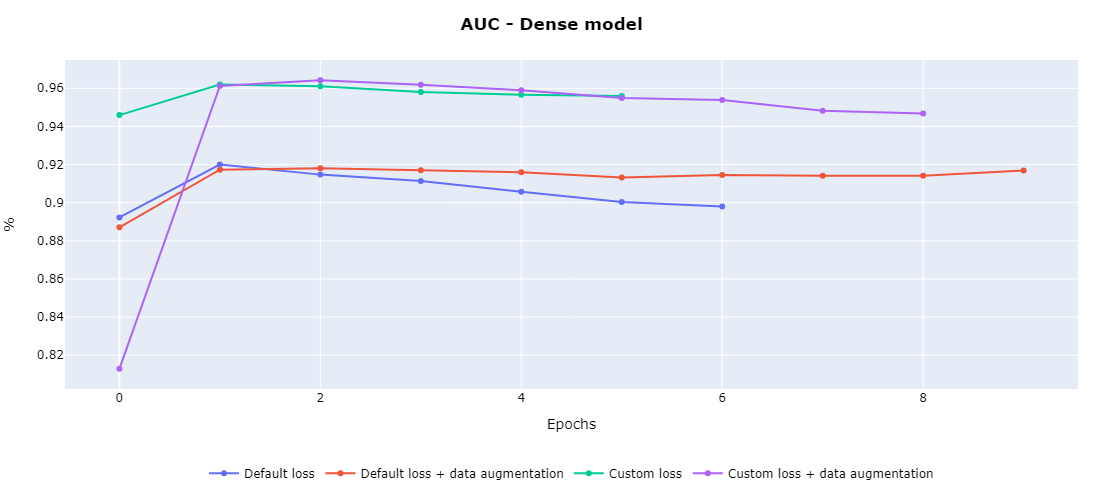

In [375]:
# Plot AUC with Plotly
history_model1_1 = pd.read_csv("./stats/history_model1_Dense_lossD.csv")
history_model1_1.model_name="Default loss"
history_model1_2 = pd.read_csv("./stats/history_model1_Dense_lossD_aug.csv")
history_model1_2.model_name="Default loss + data augmentation"
history_model1_3 = pd.read_csv("./stats/history_model1_Dense_lossC.csv")
history_model1_3.model_name="Custom loss"
history_model1_4 = pd.read_csv("./stats/history_model1_Dense_lossC_aug.csv")
history_model1_4.model_name="Custom loss + data augmentation"

history_model1 = pd.concat([history_model1_1,history_model1_2,history_model1_3,history_model1_4]).reset_index()
history_model1 = history_model1[history_model1['index']>-10] #exclude first epoch for better visibility

fig = px.line(history_model1, x="index", y="val_auc", color='model_name',markers=True)

# update plotly layout
fig.update_xaxes(title="Epochs")
fig.update_yaxes(title="%")
fig.update_layout(
            title_text="<b>AUC - Dense model</b>",
            title_x=0.5,
            title_font_color="black",
            font=dict(color="black")  ,
            margin=dict(r=25, l=25),
            height=500,width=800,
            legend=dict(
                title="",
                orientation="h",
                yanchor="bottom",
                y=-0.3,
                xanchor="center",
                x=0.5,
                #bgcolor="lightGray"
            )
)
fig.show()

# !pip install --upgrade "kaleido==0.1.*"
try:
    fig.write_image('./stats/AUC_Dense_model.png')
except:
    print("Error write_image")


>🔑 **Note:** 
>
>Applying our `custom binary cross-entropy loss function with class weights` and `text data augmentation` (using googletrans API) resulted in a **4%** increase in AUC.
>
>Both techniques will be used in future models.

# Model2: LSTM

In [184]:
tf.random.set_seed(42)
np.random.seed(42)

# model2 layers
model2_layers = [layers.Bidirectional(layers.LSTM(32,activation="tanh")), # 'tanh' activation gave better results than 'relu'.
                 layers.Dropout(0.2),
                 layers.Dense(16,activation="relu"),
                 layers.Dropout(0.2)]


# Custom loss + data augmentation
model2 = build_model(model2_layers,"model2_LSTM_lossC_aug_tanh",loss_functions[1])
probs2,preds2,df_metrics2,roc2,cls_report2 = train_evaluate_model(model2,train_dataset_aug,test_dataset,y_test,labels,epochs=5)

# Save ROCs to csv file
roc_model2 = pd.DataFrame([{model2.name:roc2}],index=["ROC"]).T.reset_index()
roc_model2.to_csv("./stats/roc_model2_tanh.csv",index=False)

# Model3: GRU

In [185]:
tf.random.set_seed(42)

# model3 layers
model3_layers = [layers.Bidirectional(layers.GRU(32,activation="relu")),
                 layers.Dropout(0.2),
                 layers.Dense(16,activation="relu"),
                 layers.Dropout(0.2)]

# Custom loss + data augmentation
model3 = build_model(model3_layers,"model3_GRU_lossC_aug",loss_functions[1])
probs3,preds3,df_metrics3,roc3,cls_report3 = train_evaluate_model(model3,train_dataset_aug,test_dataset,y_test,labels,epochs=5)

# Save ROCs to csv file
roc_model3 = pd.DataFrame([{model3.name:roc3}],index=["ROC"]).T.reset_index()
roc_model3.to_csv("./stats/roc_model3.csv",index=False)

# Model4: Conv1D

In [186]:
tf.random.set_seed(42)

# model4 layers
model4_layers = [layers.Conv1D(128,3,activation="relu"),
                 layers.GlobalAvgPool1D(),
                 layers.Dropout(0.2),
                 layers.Dense(64,activation="relu"),
                 layers.Dropout(0.2)]

# Custom loss + data augmentation
model4 = build_model(model4_layers,"model4_Conv1D_lossC_aug",loss_functions[1])
probs4,preds4,df_metrics4,roc4,cls_report4 = train_evaluate_model(model4,train_dataset_aug,test_dataset,y_test,labels,epochs=5)

# Save ROCs to csv file
roc_model4 = pd.DataFrame([{model4.name:roc4}],index=["ROC"]).T.reset_index()
roc_model4.to_csv("./stats/roc_model4.csv",index=False)

# Compare the results
We'll compare the results of each model and see which one performed best.

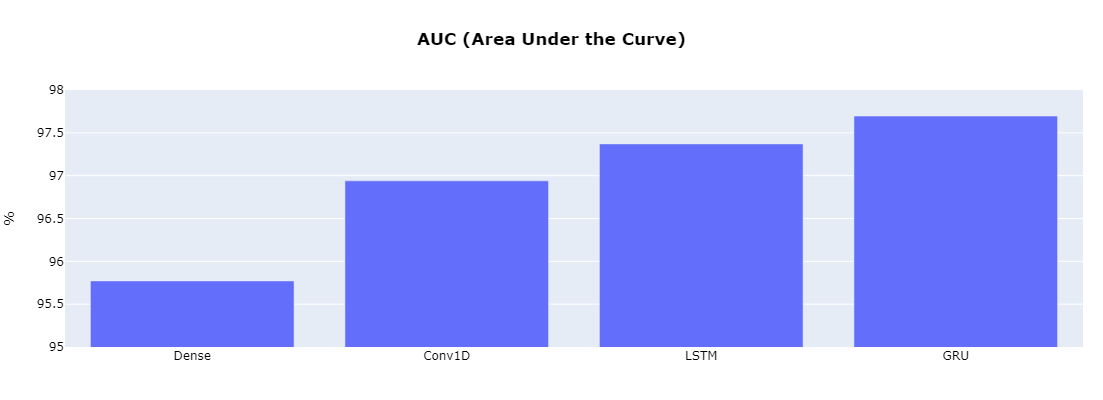

In [377]:
# Average ROC AUC
roc1_df = pd.read_csv("./stats/roc_model1.csv")
roc2_df = pd.read_csv("./stats/roc_model2.csv")
roc3_df = pd.read_csv("./stats/roc_model3.csv")
roc4_df = pd.read_csv("./stats/roc_model4.csv")

average_AUC = 100*(pd.concat([roc1_df,roc2_df,roc3_df,roc4_df]).set_index("index"))
average_AUC = average_AUC.loc[["model1_Dense_lossC_aug","model2_LSTM_lossC_aug_tanh","model3_GRU_lossC_aug","model4_Conv1D_lossC_aug"]]
average_AUC = average_AUC.rename(columns={"ROC":"AUC"},
                                 index={"model1_Dense_lossC_aug":"Dense",
                                        "model2_LSTM_lossC_aug_tanh":"LSTM",
                                        "model3_GRU_lossC_aug":"GRU",
                                        "model4_Conv1D_lossC_aug":"Conv1D"}
                                )
average_AUC = average_AUC.sort_values("AUC")

# Plot with Plotly

fig = px.bar(average_AUC, x=average_AUC.index, y= "AUC")
fig.update_xaxes(title="")
fig.update_yaxes(title="%",range=[95, 98])
fig.update_layout(height=400,
                  title_text="<b>AUC (Area Under the Curve)</b>",
                  title_x=0.5,
                  title_font_color="black",
                  font=dict(color="black"),
                  margin=dict(r=20, t=90, b=40, l=20),
        )
fig.show()

# !pip install --upgrade "kaleido==0.1.*"
try:
    fig.write_image('./stats/AUC_per_model.png')
except:
    print("Error write_image")

The `GRU` model performed best with an AUC of **97.4%**, **0.1%** ahead of the `LSTM` model.

In [379]:
# Display the `precision` and `recall` by label and class
df_metrics1_lossC_aug = pd.read_csv("./stats/metrics_model1_Dense_lossC_aug.csv")
df_metrics1_lossC = pd.read_csv("./stats/metrics_model1_Dense_lossC.csv")
df_metrics1_lossD_aug = pd.read_csv("./stats/metrics_model1_Dense_lossD_aug.csv")
df_metrics1_lossD = pd.read_csv("./stats/metrics_model1_Dense_lossD.csv")
df_metrics2_lossC_aug = pd.read_csv("./stats/metrics_model2_LSTM_lossC_aug_tanh.csv")
df_metrics3_lossC_aug = pd.read_csv("./stats/metrics_model3_GRU_lossC_aug.csv")
df_metrics4_lossC_aug = pd.read_csv("./stats/metrics_model4_Conv1D_lossC_aug.csv")

df_metrics = pd.concat([df_metrics1_lossC_aug,df_metrics1_lossC,df_metrics1_lossD_aug,df_metrics1_lossD,
                       df_metrics2_lossC_aug,df_metrics3_lossC_aug,df_metrics4_lossC_aug])

metrics_list = ["f1-score","precision","recall"]
# metric = metrics_list[2] #recall

class_list = ['0','1','weighted avg']
# class_name = class_list[1] #class 1

def return_results(metric,class_name):

    print(f"{metric} by label where class = {class_name}")
    recap = df_metrics[df_metrics["class"]==class_name]\
            .pivot_table(values=metric, 
                         index="category", 
                         columns="model_name",
                         aggfunc="mean")\
            .sort_values(by="category",ascending=False)
    recap = recap.rename(columns={"model1_Dense_lossD":"Dense (default loss)",
                                  "model1_Dense_lossD_aug":"Dense (default loss + augmentation)",
                                  "model1_Dense_lossC":"Dense (custom loss)",
                                  "model1_Dense_lossC_aug":"Dense (custom loss + augmentation)",
                                  "model2_LSTM_lossC_aug_tanh":"LSTM (custom loss + augmentation)",
                                  "model3_GRU_lossC_aug":"GRU (custom loss + augmentation)",
                                  "model4_Conv1D_lossC_aug":"Conv1D (custom loss + augmentation)"}
                        ).round(2)
    
    recap = recap[['Dense (default loss)','Dense (default loss + augmentation)','Dense (custom loss)', 'Dense (custom loss + augmentation)',
                    'Conv1D (custom loss + augmentation)','LSTM (custom loss + augmentation)', 'GRU (custom loss + augmentation)']]
    
    return recap

In [380]:
metrics_list = ["f1-score","precision","recall"]
metric = metrics_list[2] #recall
class_list = ['0','1','weighted avg']
class_name = class_list[1] #class 1

recall = return_results(metric,class_name)
recall

recall by label where class = 1


model_name     Dense (default loss)  Dense (default loss + augmentation)  \
category                                                                   
toxic                          0.49                                 0.66   
threat                         0.01                                 0.07   
severe_toxic                   0.07                                 0.15   
obscene                        0.39                                 0.47   
insult                         0.38                                 0.51   
identity_hate                  0.02                                 0.45   

model_name     Dense (custom loss)  Dense (custom loss + augmentation)  \
category                                                                 
toxic                         0.93                                0.93   
threat                        0.94                                0.92   
severe_toxic                  0.95                                0.93   
obscene                       0.91                                0.93   
insult                        0.91                                0.92   
identity_hate                 0.88                                0.96   

model_name     Conv1D (custom loss + augmentation)  \
category                                             
toxic                                         0.96   
threat                                        0.99   
severe_toxic                                  0.99   
obscene                                       0.98   
insult                                        0.96   
identity_hate                                 0.94   

model_name     LSTM (custom loss + augmentation)  \
category                                           
toxic                                       0.94   
threat                                      0.94   
severe_toxic                                0.99   
obscene                                     0.98   
insult                                      0.96   
identity_hate                               0.97   

model_name     GRU (custom loss + augmentation)  
category                                         
toxic                                      0.95  
threat                                     0.95  
severe_toxic                               1.00  
obscene                                    0.98  
insult                                     0.97  
identity_hate                              0.98

- As we can see, when data augmentation and custom loss are used, there is a significant increase in recall for all labels.

In [381]:
metric = metrics_list[1] # precision
class_name = class_list[1] #class 1

f1score = return_results(metric,class_name)
f1score

precision by label where class = 1


model_name     Dense (default loss)  Dense (default loss + augmentation)  \
category                                                                   
toxic                          0.66                                 0.59   
threat                         0.33                                 0.23   
severe_toxic                   0.51                                 0.52   
obscene                        0.63                                 0.66   
insult                         0.61                                 0.61   
identity_hate                  0.19                                 0.17   

model_name     Dense (custom loss)  Dense (custom loss + augmentation)  \
category                                                                 
toxic                         0.35                                0.35   
threat                        0.02                                0.01   
severe_toxic                  0.14                                0.15   
obscene                       0.41                                0.36   
insult                        0.34                                0.29   
identity_hate                 0.06                                0.03   

model_name     Conv1D (custom loss + augmentation)  \
category                                             
toxic                                         0.31   
threat                                        0.02   
severe_toxic                                  0.11   
obscene                                       0.31   
insult                                        0.28   
identity_hate                                 0.06   

model_name     LSTM (custom loss + augmentation)  \
category                                           
toxic                                       0.38   
threat                                      0.03   
severe_toxic                                0.11   
obscene                                     0.36   
insult                                      0.31   
identity_hate                               0.07   

model_name     GRU (custom loss + augmentation)  
category                                         
toxic                                      0.37  
threat                                     0.02  
severe_toxic                               0.09  
obscene                                    0.35  
insult                                     0.32  
identity_hate                              0.06

With the exception of the minority labels _threat_ and _identity_hate_, the f1 scores for the positive class (i.e. the comment is toxic) are around 50% for all labels.

This suggests that our neural network based models can be further improved and fine-tuned

# Improvements

So far, we have been building our own embedding layer.

We can take advantage of `Transfer Learning` and use a pre-trained embedding layer, such as [BERT](https://tfhub.dev/google/collections/bert/1) available on the TensorFlow Hub.

# Conclusion

In this project, I built several neural network based models for toxic comment classification using Tensorflow. They were first trained on a cleaned and augmented text data leveraging the _NLTK_ and _googletrans_ APIs, and then evaluated using the _AUC_, _precision_ and _recall_ metrics.

I demonstrated how to deal with class imbalance using several techniques, including stratified data splitting, data augmentation, and creating a custom loss function with class weights.

A reasonable performance was achieved with the _GRU_ model with an AUC of 97.7%.